# iki farklı pipeline denenencek - preprocessing için
  1. adaptive thresholding sonrası - vertical closing
  2. binary inversion

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_sauvola

### **1. Adaptive + Sauvola + Otsu thresholding with vertical closing**

In [ ]:
def robust_preprocess_for_receipts(image_bgr,
                                   clahe_clip_limit=2.0,
                                   adaptive_block_size=31,
                                   adaptive_c_value=10,
                                   morph_kernel_size=(7, 50),
                                   debug=True):
    steps = {}

    # Step 0: Upscaling
    image_bgr = cv2.resize(image_bgr, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    steps["upscaled"] = image_bgr

    # Step 1: Grayscale
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    steps["gray"] = gray

    # Step 2: Contrast Enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    steps["clahe"] = enhanced

    # Step 3: Denoising
    denoised = cv2.fastNlMeansDenoising(enhanced, None, 30, 7, 21)
    steps["denoised"] = denoised

    # Step 4: Sharpening
    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel_sharp)
    steps["sharpened"] = sharpened

    # Step 5: Sauvola Threshold
    try:
        sauvola_thresh = threshold_sauvola(sharpened, window_size=25)
        sauvola = (sharpened > sauvola_thresh).astype(np.uint8) * 255
        sauvola = cv2.bitwise_not(sauvola)
        steps["sauvola_thresh"] = sauvola
    except:
        sauvola = None

    # Step 6: Adaptive Threshold
    try:
        adaptive = cv2.adaptiveThreshold(
            sharpened, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            adaptive_block_size,
            adaptive_c_value
        )
        steps["adaptive_thresh"] = adaptive
    except:
        adaptive = None

    # Step 7: Otsu fallback
    _, otsu = cv2.threshold(sharpened, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    steps["otsu_thresh"] = otsu

    # Step 8: Use best threshold
    if adaptive is not None and np.count_nonzero(adaptive) > 0:
        used_thresh = adaptive
    elif sauvola is not None and np.count_nonzero(sauvola) > 0:
        used_thresh = sauvola
    else:
        used_thresh = otsu
    steps["used_thresh"] = used_thresh

    # Step 9: Morphological Closing (vertical emphasis)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, morph_kernel_size)
    closed = cv2.morphologyEx(used_thresh, cv2.MORPH_CLOSE, kernel)
    steps["final_closed"] = closed

    # Step 10: Small object removal
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed, connectivity=8)
    min_area = 100
    cleaned = np.zeros_like(closed)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > min_area:
            cleaned[labels == i] = 255
    steps["final_cleaned"] = cleaned

    if debug:
        n = len(steps)
        plt.figure(figsize=(4 * n, 5))
        for i, (title, img) in enumerate(steps.items()):
            plt.subplot(1, n, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return {
        "gray": gray,
        "clahe": enhanced,
        "denoised": denoised,
        "sharpened": sharpened,
        "thresholded": used_thresh,
        "final": cleaned
    }

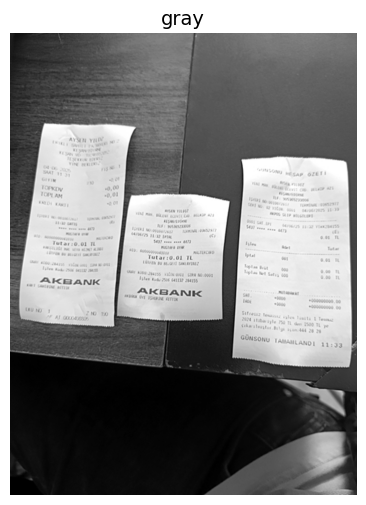

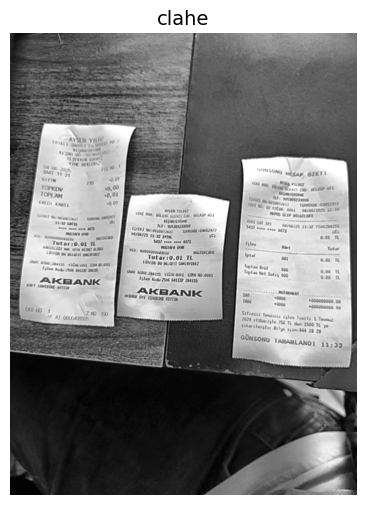

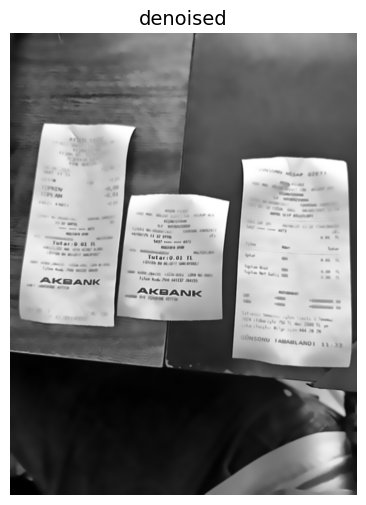

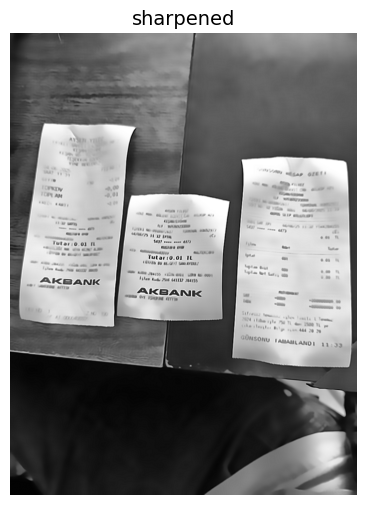

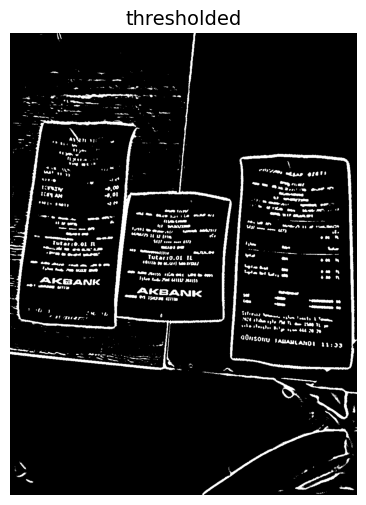

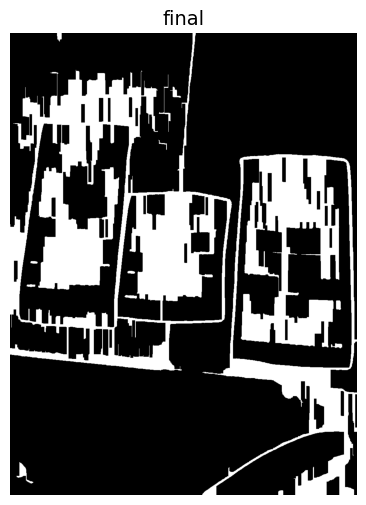

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_sauvola

# Ensure your robust_preprocess_for_receipts function is defined above.

if __name__ == "__main__":
    # Path to your receipt image
    image_path = "/content/drive/MyDrive/sampling/491701968-1-ÖKC Dokumani.jpg"

    # Read image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    # Run preprocessing
    results = robust_preprocess_for_receipts(
        image_bgr,
        clahe_clip_limit=2.0,
        adaptive_block_size=31,
        adaptive_c_value=10,
        morph_kernel_size=(7, 50),
        debug=False  # We'll handle plotting manually
    )

    # Display each stage in separate plots
    for stage_name, img in results.items():
        plt.figure(figsize=(8, 6))
        cmap_choice = "gray" if len(img.shape) == 2 else None
        plt.imshow(img, cmap=cmap_choice)
        plt.title(stage_name, fontsize=14)
        plt.axis("off")
        plt.show()


# **2. Binary Inversion**


In [15]:
import cv2
import numpy as np

def preprocess_for_detection(img_bgr):
    """
    Preprocesses an image for receipt detection:
    - Converts to grayscale
    - Denoises
    - Boosts contrast using CLAHE
    - Upscales to help thin text strokes
    - Applies adaptive thresholding
    - Conditionally inverts to ensure dark text on light background

    Returns:
        bin_img: np.uint8, single-channel 0/255 binary image (dark text = 0)
    """
    # 1) Grayscale
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 2) Light denoising
    gray = cv2.fastNlMeansDenoising(gray, h=10)

    # 3) CLAHE contrast boost
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    # 4) Upscale
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # 5) Adaptive threshold
    bin_img = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
        31, 5
    )

    # 6) Conditional inversion
    white_ratio = cv2.countNonZero(bin_img) / bin_img.size
    if white_ratio < 0.5:
        bin_img = cv2.bitwise_not(bin_img)

    return bin_img


In [28]:
import cv2
import numpy as np

def text_density_map(bin_img, k=25):
    """
    bin_img: 0/255, text ~ 0 (black)
    Returns a float32 heatmap in [0,1] where high = dense text.
    """
    # text mask: 1 for text, 0 for background
    text = (255 - bin_img) // 255
    text = text.astype(np.uint8)

    # aggregate text using a box filter (big kernel)
    k = int(k)
    heat = cv2.boxFilter(text, ddepth=cv2.CV_32F, ksize=(k, k), normalize=True)
    return heat  # 0..1

def threshold_heatmap(heat, method="percentile", p=90):
    """
    heat: float32 in [0,1]
    Returns a 0/255 mask of dense-text regions.
    """
    H = (heat * 255).astype(np.uint8)
    if method == "otsu":
        _, mask = cv2.threshold(H, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        t = np.percentile(H, p)
        _, mask = cv2.threshold(H, int(t), 255, cv2.THRESH_BINARY)
    return mask

def clean_and_find_boxes(mask, min_area_frac=0.06, aspect_low=0.3, aspect_high=2.8,
                         rectangularity_min=0.70, fill_min=0.12):
    """
    mask: 0/255 dense-text regions
    Returns list of boxes [(x,y,w,h), ...] sorted by area desc.
    """
    H, W = mask.shape[:2]
    min_area = min_area_frac * (H * W)

    # bridge gaps & denoise
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 21))
    kernel_open  = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    m = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    m = cv2.morphologyEx(m, cv2.MORPH_OPEN,  kernel_open,  iterations=1)

    # find contours
    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        if area < min_area:
            continue

        # aspect & rectangularity
        ar = w / float(h) if h else 0
        if not (aspect_low <= ar <= aspect_high):
            continue
        rect_area = cv2.contourArea(c)
        rectangularity = rect_area / float(area + 1e-6)
        if rectangularity < rectangularity_min:
            continue

        # fill ratio: how much of box is "dense text"
        roi = m[y:y+h, x:x+w]
        fill = cv2.countNonZero(roi) / float(area)
        if fill < fill_min:
            continue

        boxes.append((x, y, w, h))

    boxes.sort(key=lambda b: b[2]*b[3], reverse=True)
    return boxes, m

def detect_receipt_boxes_from_binary(bin_img):
    """
    bin_img: uint8 0/255, text dark (0), background white (255)
    Returns: boxes [(x,y,w,h)], heat (float32), dense mask (uint8), cleaned mask (uint8)
    """
    H, W = bin_img.shape[:2]
    diag = (H**2 + W**2) ** 0.5

    # --- 1) Text-density heatmap (kernel scales with size) ---
    k = max(21, int(0.015 * diag))            # ~2% of diagonal; try 0.015–0.03
    heat = text_density_map(bin_img, k=k)

    # --- 2) Threshold heatmap ---
    # Lower percentile to include more of the receipt body
    dense = threshold_heatmap(heat, method="percentile", p=85)  # was 85

    # --- 3) Morphological expansion to turn text islands -> big receipt blobs ---
    # Anisotropic closing: bridge lines vertically & horizontally
    k_close_v = (max(7, int(0.012 * W)), max(35, int(0.06 * H)))  # skinny x tall
    k_close_h = (max(35, int(0.06 * W)), max(7, int(0.012 * H)))  # wide x short
    close_v = cv2.morphologyEx(dense, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, k_close_v), iterations=1)
    close_h = cv2.morphologyEx(close_v, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, k_close_h), iterations=1)

    # Mild open to remove thin noise, then a fat dilation to fill white receipt interiors
    k_open  = (max(5, int(0.008 * W)), max(5, int(0.008 * H)))
    k_dilat = (max(25, int(0.03 * W)), max(25, int(0.03 * H)))
    m = cv2.morphologyEx(close_h, cv2.MORPH_OPEN,  cv2.getStructuringElement(cv2.MORPH_RECT, k_open),  iterations=1)
    m = cv2.dilate(m, cv2.getStructuringElement(cv2.MORPH_RECT, k_dilat), iterations=1)

    # --- 4) Find contours, merge by convex hull, and box each blob ---
    cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    min_area_frac = 0.04                      # a bit lower since we expanded blobs
    aspect_low, aspect_high = 0.25, 4.0       # wider aspect tolerance for multi-receipts
    rectangularity_min = 0.55                 # lower; we’ll rely on dilation to regularize

    min_area = min_area_frac * (H * W)
    for c in cnts:
        if cv2.contourArea(c) < min_area:
            continue

        # Optional: convex hull to regularize ragged shapes
        hull = cv2.convexHull(c)
        x, y, w, h = cv2.boundingRect(hull)
        ar = w / float(h) if h else 0.0
        if not (aspect_low <= ar <= aspect_high):
            continue

        # rectangularity on hull vs bounding box
        rect_area = cv2.contourArea(hull)
        rectangularity = rect_area / float(w * h + 1e-6)
        if rectangularity < rectangularity_min:
            continue

        boxes.append((x, y, w, h))

    boxes.sort(key=lambda b: b[2] * b[3], reverse=True)
    return boxes, heat, dense, m


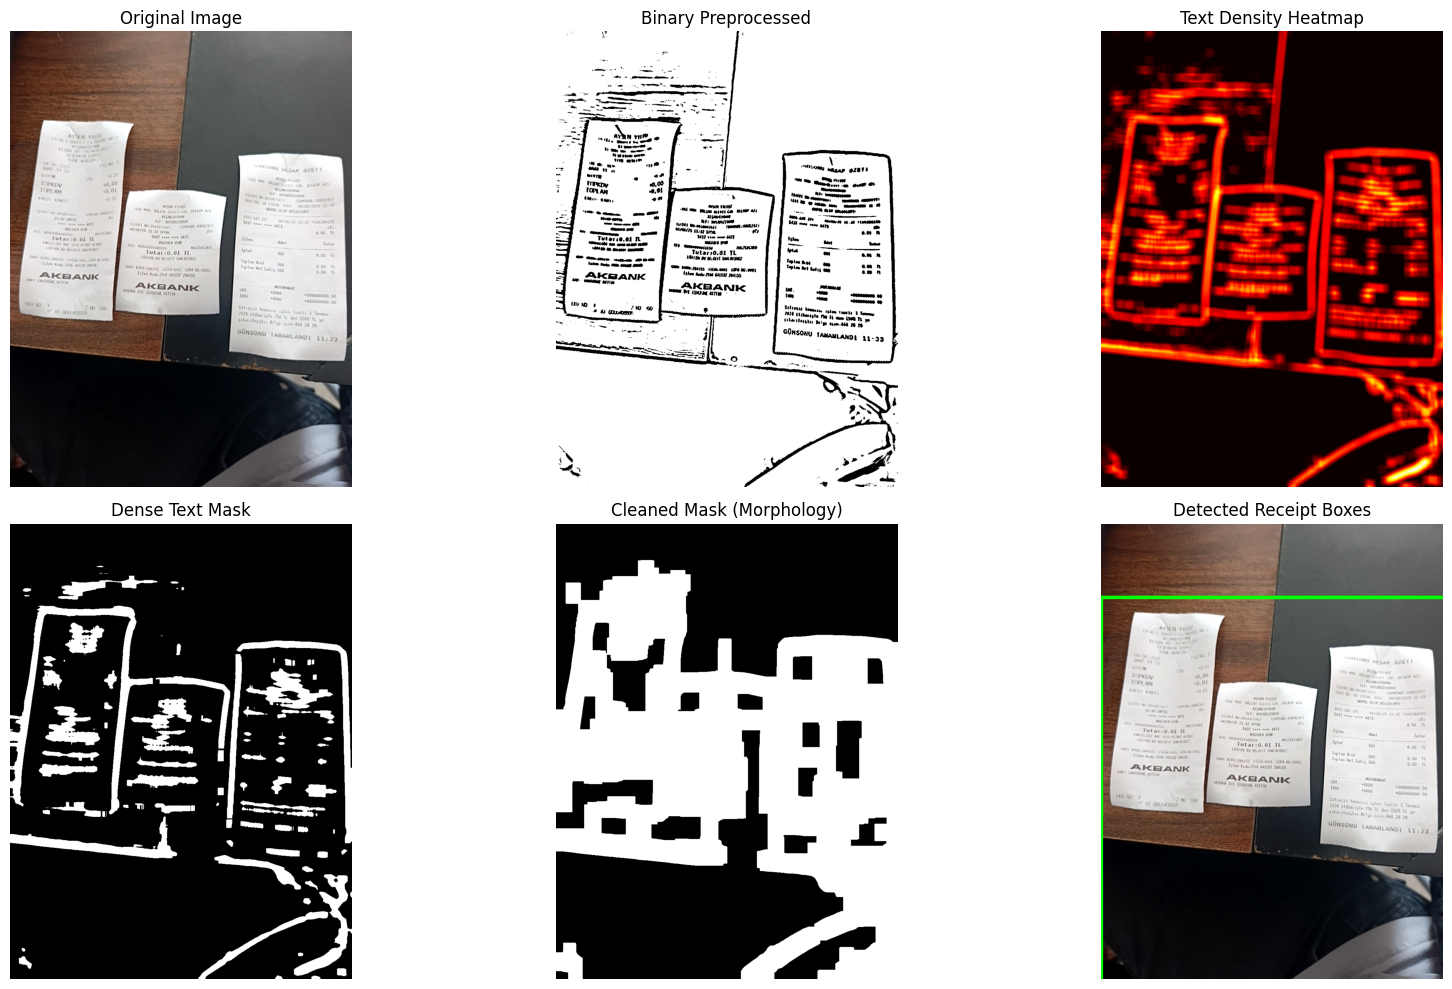

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Make sure your preprocess_for_detection, text_density_map,
# threshold_heatmap, detect_receipt_boxes_from_binary functions are defined above.

if __name__ == "__main__":
    # Path to your input receipt image
    image_path = "/content/drive/MyDrive/sampling/491701968-1-ÖKC Dokumani.jpg"
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # --- STEP 1: Preprocess to binary ---
    bin_img = preprocess_for_detection(img_bgr)

    # --- STEP 2: Detect receipt boxes ---
    boxes, heat, dense, cleaned_mask = detect_receipt_boxes_from_binary(bin_img)

    # --- STEP 3: Draw bounding boxes ---
    img_with_boxes = img_bgr.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 3)

    # --- STEP 4: Display each stage ---
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(bin_img, cmap="gray")
    plt.title("Binary Preprocessed")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(heat, cmap="hot")
    plt.title("Text Density Heatmap")
    plt.axis("off")

    plt.subplot(2, 3, 4)
    plt.imshow(dense, cmap="gray")
    plt.title("Dense Text Mask")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(cleaned_mask, cmap="gray")
    plt.title("Cleaned Mask (Morphology)")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Detected Receipt Boxes")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
